# [ PART 05. 정형 데이터마이닝 ] - 2장. 분류 분석
- 분류분석은 데이터가 어떤 그룹에 속하는지 예측하는데 사용하는 기법.
- 의사결정나무, 앙상블기법, 인공신경망 등이 있음.
- ADP 실기에서는 "분류기법들을 활용해 가장 정확도같은 지표가 좋은 기법과 결과를 보고서에 나타내라"는 형식의 문제가 출제됨.

## - 불러올 패키지 목록

In [1]:
# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols

import statsmodels.regression.linear_model


from sklearn.model_selection import train_test_split    # training/test data set을 추출하는 패키지
from sklearn.linear_model import *    # 로지스틱 회귀 분석을 위한 패키지
from sklearn.metrics import *
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler



## 1. 로지스틱 회귀분석
- 반응변수가 범주형인 경우 적용되는 회귀분석
- 새로운 설명변수가 주어질 때 반응변수의 각 범주에 속할 확률이 얼마인지를 추정하여 추정확률을 기준치에 따라 분류하는 목적으로 활용

In [ ]:
# 데이터 로드 및 데이터프레임 생성
df_credit = pd.read_csv( 'C:/Users/Administrator/GitHub/TIL/ADP_study/rawdata/credit_final.csv')


# 회귀모델의 상수항에 해당하는 컬럼 추가
df_credit = sm.add_constant( df_credit,
                             has_constant = "add" )

df_credit.head()

In [ ]:
# 독립변수, 종속변수 지정
x = df_credit.drop('credit.rating', axis = 1)
y = df_credit['credit.rating']


# 데이터 분할 : train 70%, test 30%
train_x, test_x, train_y, test_y = train_test_split( x, y,
                                                     train_size = 0.7, test_size = 0.3,
                                                     random_state = 153 )

print( 'train_x', train_x.shape,'\n', 'test_x', test_x.shape)
print( 'train_y', train_y.shape,'\n', 'test_y', test_y.shape)

### sklearn 패키지 사용

In [ ]:
# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegressionCV(max_iter = 1000)
lr_clf.fit( train_x, train_y )

In [ ]:
lr_preds = lr_clf.predict(test_x)

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(test_y, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(test_y , lr_preds)))

### statsmodels 패키지 사용

In [ ]:
# 로지스틱 회귀분석 실행

model = sm.Logit(train_y, train_x)
result = model.fit()

In [ ]:
print( result.summary() )

In [ ]:
df_credit.info()

In [ ]:
# 독립변수, 종속변수 지정
x2 = df_credit[ ['account.balance', 'credit.duration.months', 'previous.credit.payment.status',
                 'savings', 'credit.purpose', 'current.assets', 'apartment.type', 'foreign.worker',
                 'guarantor', 'age', 'other.credits', 'marital.status', 'installment.rate'] ]
y = df_credit['credit.rating']


# 데이터 분할 : train 70%, test 30%
train_x, test_x, train_y, test_y = train_test_split( x2, y,
                                                     train_size = 0.7, test_size = 0.3,
                                                     stratify = y,
                                                     random_state = 153 )

print( 'train_x', train_x.shape,'\n', 'test_x', test_x.shape)
print( 'train_y', train_y.shape,'\n', 'test_y', test_y.shape)

In [ ]:
# 로지스틱 회귀분석 실행

model = sm.Logit(train_y, train_x)
result = model.fit()

In [ ]:
print( result.summary() )

## 2. 의사결정나무

In [2]:
# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

# 사이킷런 패키지
from sklearn.model_selection import *  # 데이터 분리, 검증 및 파라미터 튜닝을 위한 모듈
from sklearn.tree import *  # 의사결정나무 관련 모듈
from sklearn.ensemble import *
from sklearn.metrics import *

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 시각화를 위한 모듈
from matplotlib import pyplot as plt
import seaborn as sb
# %matplotlib inline 의 목적은 plt.show()함수가 호출되지 않은 경우에도 matplotlib 다이어그램을 렌더링하는 것이다.
# 그러나 현재 업데이트된 버전의 주피터 노트북 버전에서는 %matplotlib inline 를 사용하지 않더라도 Matplotlib 다이어그램을 개체로 표현한다.
# 따라서 굳이 필요하지는 않다. 그러나 코드를 깨끗하게 유지하고 자신이 만든 플롯을 호출하기 위해 여전히 관례적으로 권장된다.
%matplotlib inline

# label별 데이터 카운트를 위한 모듈
from collections import Counter  # https://docs.python.org/3/library/collections.html

In [3]:
# 데이터 로드 및 데이터프레임 생성
df_credit = pd.read_csv( 'C:/Users/Administrator/GitHub/TIL/ADP_study/rawdata/credit_final.csv')
df_credit.index = df_credit.index + 1

df_credit = df_credit.astype({'credit.rating':str})

In [4]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 1 to 1000
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   credit.rating                   1000 non-null   object
 1   account.balance                 1000 non-null   int64 
 2   credit.duration.months          1000 non-null   int64 
 3   previous.credit.payment.status  1000 non-null   int64 
 4   credit.purpose                  1000 non-null   int64 
 5   credit.amount                   1000 non-null   int64 
 6   savings                         1000 non-null   int64 
 7   employment.duration             1000 non-null   int64 
 8   installment.rate                1000 non-null   int64 
 9   marital.status                  1000 non-null   int64 
 10  guarantor                       1000 non-null   int64 
 11  residence.duration              1000 non-null   int64 
 12  current.assets                  1000 non-null   

In [8]:
# 목표변수와 나머지 변수들을 따로 저장

y = df_credit['credit.rating']
x = df_credit.loc[ :, 'account.balance':'foreign.worker']

In [9]:
# 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split( x, y,
                                                     test_size = 0.3,
                                                     random_state = 153 )

print(Counter(y_train))
print()
print(Counter(y_test))

Counter({'1': 495, '0': 205})

Counter({'1': 205, '0': 95})


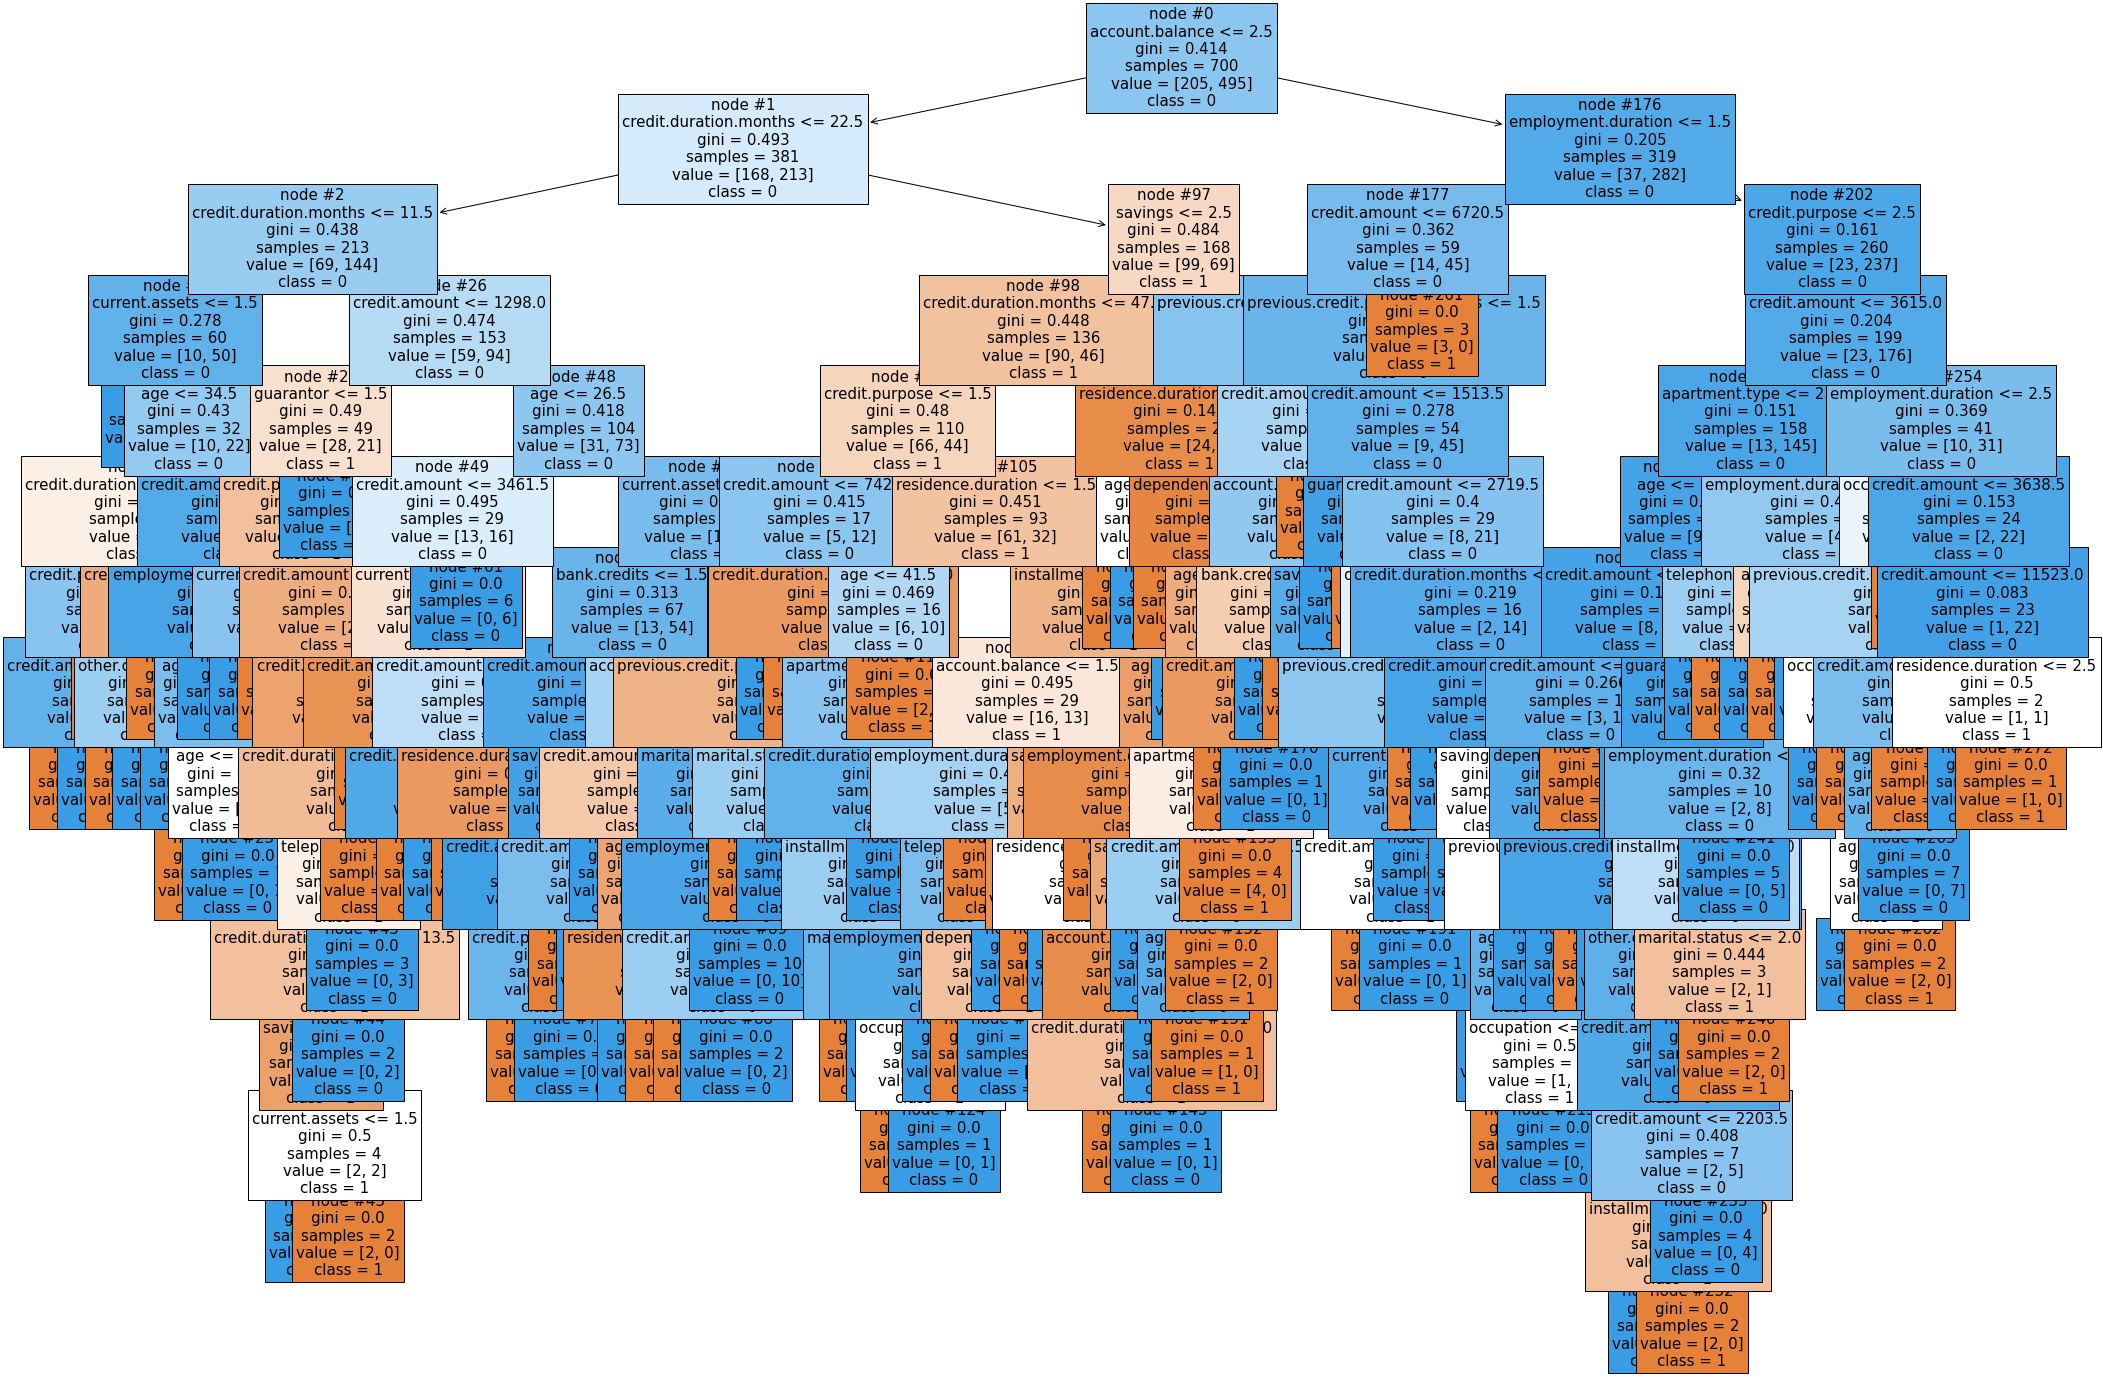

In [29]:
model = DecisionTreeClassifier( random_state = 153 )

model.fit(x_train, y_train)


plt.figure( figsize=(35, 25) )
plot_tree( model,
           class_names = list(df_credit['credit.rating'].unique()),
           feature_names = list( df_credit.drop('credit.rating', axis = 1) ),
           filled = True,
           node_ids = True,
           fontsize = 15 )     
plt.show()

                           feature  importance
0                  account.balance    0.154267
1           credit.duration.months    0.113371
2   previous.credit.payment.status    0.039792
3                   credit.purpose    0.041063
4                    credit.amount    0.209011
5                          savings    0.060049
6              employment.duration    0.040589
7                 installment.rate    0.020437
8                   marital.status    0.020174
9                        guarantor    0.030004
10              residence.duration    0.038776
11                  current.assets    0.046677
12                             age    0.089275
13                   other.credits    0.009762
14                  apartment.type    0.021668
15                    bank.credits    0.014764
16                      occupation    0.025191
17                      dependents    0.008383
18                       telephone    0.016747
19                  foreign.worker    0.000000



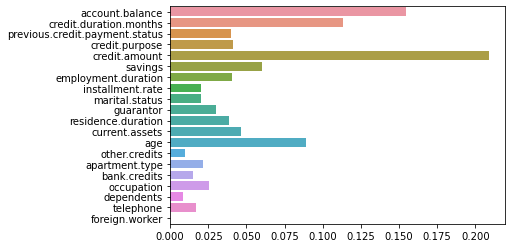

In [30]:
# 입력변수들의 중요도 확인(확률값)

ft_impt = pd.DataFrame( {'feature' : x_train.columns,
                         'importance' : model.feature_importances_} )

print( ft_impt )
print()

sb.barplot( x = model.feature_importances_,
            y = list( df_credit.drop('credit.rating', axis=1) ) )
plt.show()

In [31]:
# 파라미터 목록 확인
list( model.get_params().keys() )

['ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'random_state',
 'splitter']

In [32]:
# 평가할 파라미터 split 조건 설정

params = { 'max_depth' : [3, 4, 5, 6, 10],
           'min_samples_split' : [5, 10, 15, 20, 25],
           'min_samples_leaf' : [5, 10, 15, 20, 25] }

grid = GridSearchCV( model,
                     param_grid = params,
                     cv = 10,
                     scoring = 'accuracy')

# split 조건별로 하이퍼 파라미터 학습/평가
grid.fit( x, y )

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=153),
             param_grid={'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [5, 10, 15, 20, 25],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             scoring='accuracy')

In [33]:
df_grid = pd.DataFrame( grid.cv_results_ )

df_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            125 non-null    float64
 1   std_fit_time             125 non-null    float64
 2   mean_score_time          125 non-null    float64
 3   std_score_time           125 non-null    float64
 4   param_max_depth          125 non-null    object 
 5   param_min_samples_leaf   125 non-null    object 
 6   param_min_samples_split  125 non-null    object 
 7   params                   125 non-null    object 
 8   split0_test_score        125 non-null    float64
 9   split1_test_score        125 non-null    float64
 10  split2_test_score        125 non-null    float64
 11  split3_test_score        125 non-null    float64
 12  split4_test_score        125 non-null    float64
 13  split5_test_score        125 non-null    float64
 14  split6_test_score        1

In [34]:
pd.set_option('display.max_colwidth', None)  # 데이터프레임의 셀 폭 설정 (한 셀의 너비에 내용이 다 안들어갈 경우)
pd.set_option('display.max_row', 100)  # 데이터프레임의 셀 폭 설정 (한 셀의 너비에 내용이 다 안들어갈 경우)

df_grid[ ['params','mean_test_score','rank_test_score'] ].sort_values(['rank_test_score'])

,params,mean_test_score,rank_test_score
33,"{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 20}",0.743,1
31,"{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}",0.743,1
30,"{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}",0.743,1
32,"{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 15}",0.743,1
57,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 15}",0.743,5
...,...,...,...
95,"{'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 5}",0.717,117
75,"{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5}",0.713,122
76,"{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10}",0.713,122
101,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}",0.699,124


In [35]:
print("최고 Score: ", str(np.round(grid.best_score_ ,4)))
print("최적 Parameters: ",str(grid.best_params_))
print("최적 Estimators: ",str(grid.best_estimator_))

최고 Score:  0.743
최적 Parameters:  {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}
최적 Estimators:  DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=5,
                       random_state=153)


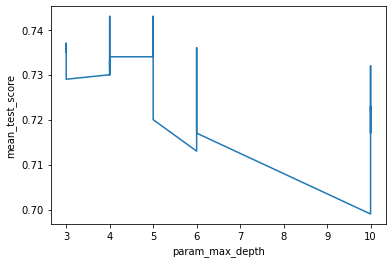

In [36]:
# max_depth 에 따른 평가결과 차이 확인
plt.plot( df_grid['param_max_depth'], df_grid['mean_test_score'] )
plt.xlabel( 'param_max_depth' )
plt.ylabel( 'mean_test_score' )
plt.show()

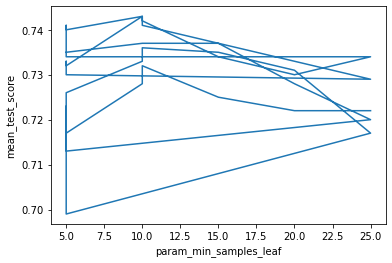

In [37]:
# min_samples_leaf 에 따른 평가결과 차이 확인
plt.plot( df_grid['param_min_samples_leaf'], df_grid['mean_test_score'] )
plt.xlabel( 'param_min_samples_leaf' )
plt.ylabel( 'mean_test_score' )
plt.show()

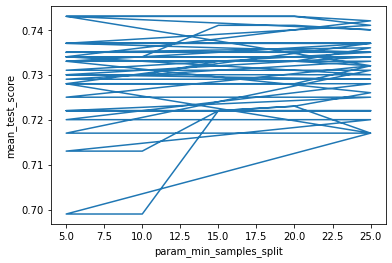

In [38]:
# min_samples_split 에 따른 평가결과 차이 확인
plt.plot( df_grid['param_min_samples_split'], df_grid['mean_test_score'] )
plt.xlabel( 'param_min_samples_split' )
plt.ylabel( 'mean_test_score' )
plt.show()

                           feature  importance
0                  account.balance    0.456585
1           credit.duration.months    0.263555
2   previous.credit.payment.status    0.000000
3                   credit.purpose    0.015116
4                    credit.amount    0.101074
5                          savings    0.102508
6              employment.duration    0.025816
7                 installment.rate    0.000000
8                   marital.status    0.000000
9                        guarantor    0.000000
10              residence.duration    0.000000
11                  current.assets    0.035346
12                             age    0.000000
13                   other.credits    0.000000
14                  apartment.type    0.000000
15                    bank.credits    0.000000
16                      occupation    0.000000
17                      dependents    0.000000
18                       telephone    0.000000
19                  foreign.worker    0.000000



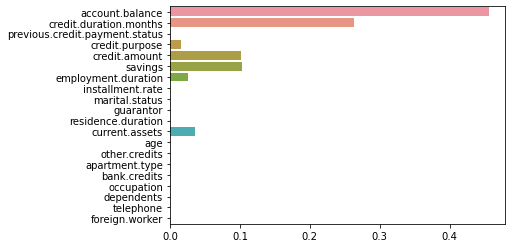

In [40]:
# 의사결정트리 생성
model = DecisionTreeClassifier( max_depth = 4,
                                min_samples_leaf = 10,
                                min_samples_split = 5,
                                random_state = 156 )

# 모델 학습
model.fit( x_train, y_train )


# 입력변수들의 중요도 확인(확률값)

ft_impt = pd.DataFrame( {'feature' : x_train.columns,
                         'importance' : model.feature_importances_} )

print( ft_impt )
print()

sb.barplot( x = model.feature_importances_,
            y = list( df_credit.drop('credit.rating', axis=1) ) )
plt.show()

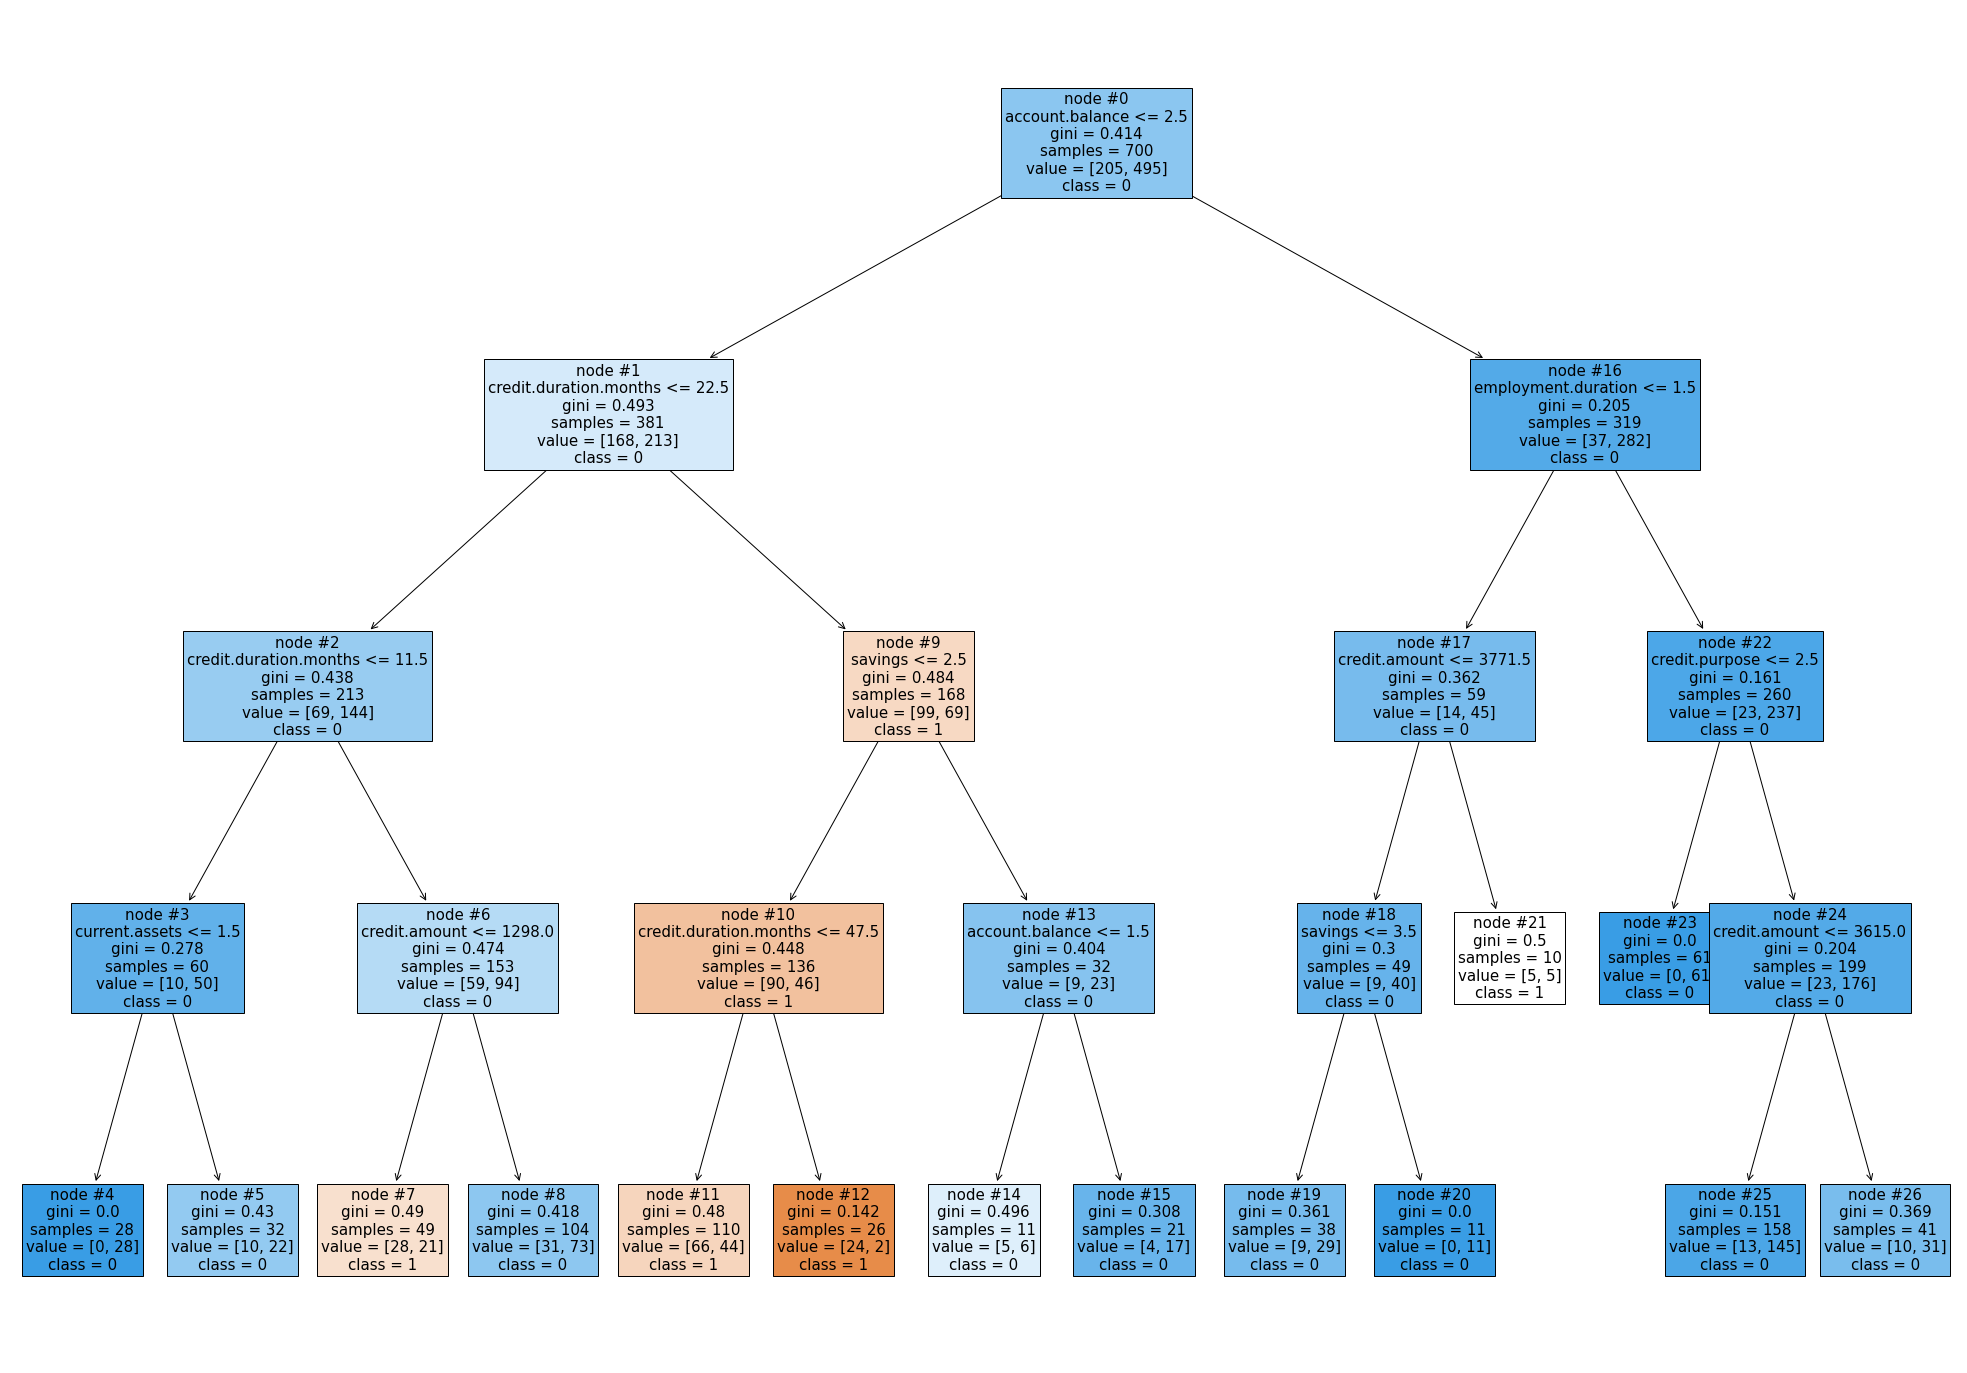

In [41]:
# 시각화
plt.figure( figsize=(35, 25) )
plot_tree( model,
           class_names = list(df_credit['credit.rating'].unique()),
           feature_names = list( df_credit.drop('credit.rating', axis = 1) ),
           filled = True,
           node_ids = True,
           fontsize = 15 )     
plt.show()

In [42]:
proba = model.predict_proba(x_test)

df_proba = pd.DataFrame( proba, columns = model.classes_ )

df_proba.head()

,0,1
0,0.600000,0.400000
1,0.190476,0.809524
2,0.571429,0.428571
3,0.082278,0.917722
4,0.236842,0.763158


In [ ]:
# AUC 계산
print('AUC: ', roc_auc_score( result_1, proba_1 ) )

# ROC curve 출력
fpr, tpr, thresholds = roc_curve( y_test, proba_1,
                                  pos_label='setosa')

RocCurveDisplay( fpr, tpr).plot()

plt.plot( [0,1], [0,1],
          label = 'Random')
plt.show()